In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [14]:
import random
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.preprocessing import StandardScaler , LabelEncoder
from tqdm import tqdm

In [15]:
# กำหนด path ของชุดข้อมูล
DATA_DIR = "/kaggle/input/io-t-sleep-stage-classification-version-2/train/train"

# ค้นหาไฟล์ CSV ทั้งหมด
csv_files = glob(os.path.join(DATA_DIR, "*.csv"))
print(f"พบไฟล์ข้อมูลทั้งหมด: {len(csv_files)} ไฟล์")


พบไฟล์ข้อมูลทั้งหมด: 83 ไฟล์


In [16]:
# ฟังก์ชันสำหรับการแปลง Time-Series Data ด้วย FFT
def preprocess_time_series_with_fft(files, is_training=True, window_size=480):
    feature_segments = []
    label_segments = [] if is_training else None

    # การแปลงค่า Sleep_Stage
    stage_mapping = {"W": 0, "R": 1, "N": 2}  # Mapping ค่า Sleep_Stage เป็นตัวเลข

    for file in tqdm(files, desc="Processing Files"): 
        df = pd.read_csv(file)

        if is_training and 'Sleep_Stage' in df.columns:
            # แปลง Sleep_Stage เป็นตัวเลข
            label_data = df['Sleep_Stage'].map(stage_mapping).values  # แปลงเป็นตัวเลขโดยใช้ map
            df = df.drop(columns=['Sleep_Stage'])  # ลบคอลัมน์ Sleep_Stage ออกจาก df

        num_windows = len(df) // window_size

        # ฟังก์ชันการแปลง Time-Series เป็น Frequency Domain โดยใช้ FFT
        def apply_fft(data):
            # แปลงสัญญาณด้วย FFT
            fft_data = np.fft.fft(data, axis=0)
            # ใช้แค่ค่าความถี่ที่สำคัญ (เช่น ค่ามอดูลัส)
            return np.abs(fft_data)

        # ตัดข้อมูลออกเป็น windows (num_windows, window_size, num_features)
        segment_data = df.values[:num_windows * window_size].reshape(num_windows, window_size, -1)
        
        # ใช้ FFT กับทุกสัญญาณใน window
        fft_segments = np.apply_along_axis(apply_fft, axis=1, arr=segment_data)
        feature_segments.append(fft_segments)

        if is_training:
            # กำหนด label โดยใช้ค่าที่พบมากที่สุดในแต่ละ window
            window_labels = label_data[:num_windows * window_size].reshape(num_windows, window_size)
            window_labels = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=window_labels)
            label_segments.append(window_labels)

    X_output = np.vstack(feature_segments)  # รวม segment ทั้งหมด
    y_output = np.hstack(label_segments) if is_training else None  # รวม label

    return (X_output, y_output) if is_training else X_output


In [17]:
# Load train data (480-row segments)
X_train, y_train_notencoded = preprocess_time_series_with_fft(csv_files, is_training=True, window_size=480)

# Normalize each feature
scaler = StandardScaler()
label_encoder = LabelEncoder()

X_train_shape = X_train.shape
# Reshape to 2D for scaling (batch * timesteps, features)
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train_shape)
y_train = label_encoder.fit_transform(y_train_notencoded)

print("Data processing complete!")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


Processing Files: 100%|██████████| 83/83 [00:55<00:00,  1.51it/s]


Data processing complete!
X_train shape: (66473, 480, 8), y_train shape: (66473,)


Randomly selected sample index: 44727


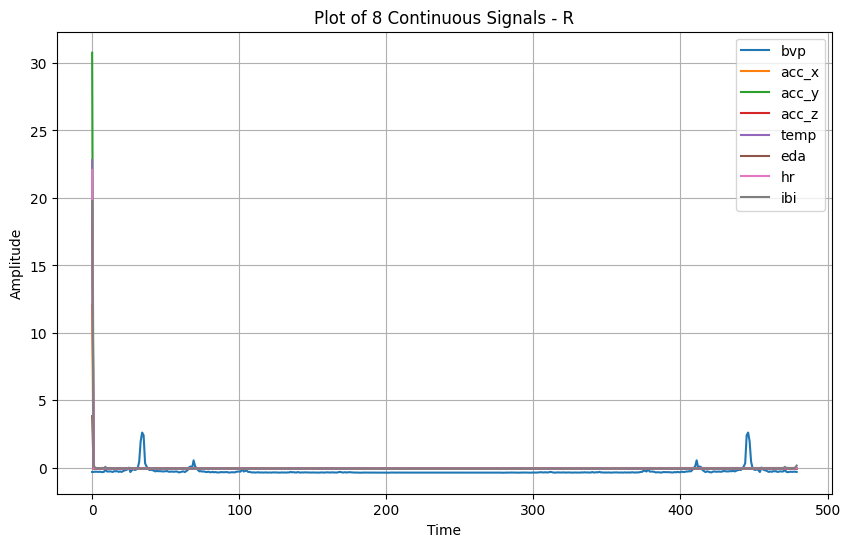

In [18]:
import random

# สมมติว่า activity_map และ y_train ถูกกำหนดไว้แล้ว
activity_map = {
    0: "N",  # N: Nap
    1: "R",  # R: Rest
    2: "W",  # W: Wake
}

# Generate a random sample index
sample_index = random.randint(0, len(y_train) - 1)  # Random index within the dataset
print(f"Randomly selected sample index: {sample_index}")

# Extract signal for the sample
signal_array = X_train[sample_index]  # Get the signal for the selected sample
time = np.arange(signal_array.shape[0])  # Time axis

# Get activity label and its name
activity_label = int(y_train[sample_index])  # Activity label for the sample
activity_name = activity_map[activity_label]

# Define the signal names (order must match the columns in the data)
signals = ['bvp', 'acc_x', 'acc_y', 'acc_z', 'temp', 'eda', 'hr', 'ibi']

# Plot the signals
plt.figure(figsize=(10, 6))
for i in range(signal_array.shape[1]):
    plt.plot(time, signal_array[:, i], label=f'{signals[i]}')

# Add labels, title, legend, and grid
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'Plot of 8 Continuous Signals - {activity_name}')
plt.legend()
plt.grid()
plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# ฟังก์ชัน f1_weighted
def f1_weighted(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1]  # ใช้ K.int_shape เพื่อหาจำนวนคลาส
    y_pred_labels = K.argmax(y_pred, axis=-1)

    f1_scores = []
    weights = []

    for i in range(num_classes):
        true_mask = K.cast(K.equal(y_true, i), 'float64')
        pred_mask = K.cast(K.equal(y_pred_labels, i), 'float64')

        tp = K.sum(true_mask * pred_mask)
        fp = K.sum(pred_mask) - tp
        fn = K.sum(true_mask) - tp

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        f1_scores.append(f1)

        class_weight = K.sum(true_mask)
        weights.append(class_weight)

    f1_scores = K.stack(f1_scores)
    weights = K.stack(weights)
    weights /= K.sum(weights) + K.epsilon()  # Normalize weights

    return K.sum(f1_scores * weights)  # Weighted average


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

# ฟังก์ชัน f1_weighted
def f1_weighted(y_true, y_pred):
    num_classes = K.int_shape(y_pred)[-1]  # ใช้ K.int_shape เพื่อหาจำนวนคลาส
    y_pred_labels = K.argmax(y_pred, axis=-1)

    f1_scores = []
    weights = []

    for i in range(num_classes):
        true_mask = K.cast(K.equal(y_true, i), 'float64')
        pred_mask = K.cast(K.equal(y_pred_labels, i), 'float64')

        tp = K.sum(true_mask * pred_mask)
        fp = K.sum(pred_mask) - tp
        fn = K.sum(true_mask) - tp

        precision = tp / (tp + fp + K.epsilon())
        recall = tp / (tp + fn + K.epsilon())

        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        f1_scores.append(f1)

        class_weight = K.sum(true_mask)
        weights.append(class_weight)

    f1_scores = K.stack(f1_scores)
    weights = K.stack(weights)
    weights /= K.sum(weights) + K.epsilon()  # Normalize weights

    return K.sum(f1_scores * weights)  # Weighted average

# สร้างโมเดล
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # 1D CNN Layer สำหรับการดึงคุณลักษณะ
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # LSTM สำหรับการเรียนรู้ลำดับ
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dropout(0.3),

    # Fully Connected Layers
    Dense(128, activation="relu"),
    Dropout(0.3),  # เพิ่ม Dropout
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")  # เนื่องจากเรามี 3 ประเภทใน Sleep_Stage
])

# คอมไพล์โมเดลโดยใช้ F1-weighted เป็น metric
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.005),  # ลด Learning Rate ลง
    metrics=[f1_weighted]  # ใช้ F1-Weighted เป็น Metric
)

# การบันทึกโมเดลที่ดีที่สุด
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# ฝึกโมเดล
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_split=0.2,
    verbose=2,
    batch_size=128,
    callbacks=[checkpoint]
)

# โหลดโมเดลที่ดีที่สุด
model.load_weights("best_model.h5")
print("โมเดลที่ดีที่สุดถูกโหลดแล้ว!")


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.76342, saving model to best_model.h5
416/416 - 21s - 51ms/step - f1_weighted: 0.6164 - loss: 0.7883 - val_f1_weighted: 0.6550 - val_loss: 0.7634
Epoch 2/100

Epoch 2: val_loss did not improve from 0.76342
416/416 - 15s - 36ms/step - f1_weighted: 0.6250 - loss: 0.7627 - val_f1_weighted: 0.6337 - val_loss: 0.7964
Epoch 3/100

Epoch 3: val_loss did not improve from 0.76342
416/416 - 15s - 36ms/step - f1_weighted: 0.6272 - loss: 0.7570 - val_f1_weighted: 0.6330 - val_loss: 0.7768
Epoch 4/100

Epoch 4: val_loss did not improve from 0.76342
416/416 - 15s - 36ms/step - f1_weighted: 0.6257 - loss: 0.7522 - val_f1_weighted: 0.6282 - val_loss: 0.7776
Epoch 5/100

Epoch 5: val_loss did not improve from 0.76342
416/416 - 15s - 37ms/step - f1_weighted: 0.6258 - loss: 0.7482 - val_f1_weighted: 0.6291 - val_loss: 0.8172
Epoch 6/100

Epoch 6: val_loss did not improve from 0.76342
416/416 - 15s - 37ms/step - f1_weighted: 0.6269 - loss: 0.7442 - val_

In [27]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

# Define the directory containing the test files
test_dir = '/kaggle/input/io-t-sleep-stage-classification-version-2/test_segment/test_segment/'

# List all the test CSV files
test_files = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith('.csv'):
            test_files.append(os.path.join(root, file))

# Sort files if needed
test_files.sort()

# Use preprocess_time_series function to load test data
X_test = preprocess_time_series_with_fft(test_files, is_training=False, window_size=480)

# Use StandardScaler to scale the test data
scaler = StandardScaler()
X_test_shape = X_test.shape
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test_shape)

# Predict using the model
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Define mapping for Sleep_Stage
activity_map = {0: "W", 1: "R", 2: "N"}  # Mapping Sleep_Stage
prediction_mapped = [activity_map[x] for x in predicted_classes]

# Create the submission dataframe
modified_test_files = [os.path.basename(file).replace('.csv', '') for file in test_files]

# Generate the submission file in the same format as before (with ID and predicted labels)
submission = pd.DataFrame({
    'id': modified_test_files,
    'labels': prediction_mapped
})

# Save the submission dataframe to CSV
submission.to_csv('rereresubmission.csv', index=False)

print("Submission file has been created!")

Processing Files: 100%|██████████| 7010/7010 [00:18<00:00, 384.47it/s]


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Submission file has been created!


In [23]:
re = pd.read_csv("/kaggle/working/rereresubmission.csv")

In [24]:
re

,ID,Sleep_Stage
0,test001_00000,N
1,test001_00001,W
2,test001_00002,W
3,test001_00003,W
4,test001_00004,W
...,...,...
7005,test010_00696,N
7006,test010_00697,N
7007,test010_00698,N
7008,test010_00699,W


In [26]:
sub = pd.read_csv("/kaggle/input/io-t-sleep-stage-classification-version-2/sample_submission.csv")
sub

,id,labels
0,test001_00000,W
1,test001_00001,W
2,test001_00002,W
3,test001_00003,NaN
4,test001_00004,NaN
...,...,...
7005,test010_00696,NaN
7006,test010_00697,NaN
7007,test010_00698,NaN
7008,test010_00699,NaN
